In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph/props"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint, initialize_models
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics
from molgen.Discretizer.sinkhorn import sinkhorn_knopp

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [4]:
model_type = "deepsets"
sys.argv = ["", "-model_type", model_type, "-one_batch_train"]
args = get_args()
args.n_epochs = 100 
args.init_model = "{}-attention-sinknew-test3".format(model_type)
# args.output_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/output_dev4/{}/".format(args.init_model)
args.output_dir = "/run/media/octav/data-volume/tum-thesis/output_dev4_saves/{}/".format(args.init_model)
args.tb_logs_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/logs_dev4/{}".format(args.init_model)
args.batch_size = 50 

In [5]:
model = args.init_model
model_iter = 12000

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)

molopt, molopt_decoder, _, pen, recpen, crossatt, _, config, _ = load_checkpoint(args.output_dir + model_name ,init_fc = initialize_models, device = args.device)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False, device = args.device)
fgw_loss = FGW(alpha = 0.5)
# pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

/run/media/octav/data-volume/tum-thesis/output_dev4_saves/deepsets-attention-sinknew-test3/model_deepsets-attention-sinknew-test3_12000
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=300, out_features=200, bias=True)
  (opt1): Linear(in_features=200, out_features=150, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=150, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=150, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=

In [6]:
# train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)
datatype = "train"
train_data_loader = get_loader("molgen/data/chembl50", datatype, 50, same_number_atoms = True)

for i in train_data_loader:
#     X = (MolGraph(i[0]))
#     Y = (MolGraph(i[1]))
    X = MolGraph(i)
    Y = X
    break

In [7]:
x_encoding, x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
# yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

pen.mirror = ""

if config.cross_att_use:
    y_encoding = molopt.GCN(Y)[0]
    cross_mats = crossatt.forward(x_embedding, y_encoding, X, model_type)
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats)
else:
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1)

pen.tau = 0.05
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss)
metrics.measure_batch(pred_pack[0], target)

/home/octav/gitrepos/tum-thesis/otgnn/models/gromov_modules.py:398: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nce_reg = torch.nn.LogSoftmax()(torch.stack(all_nce_dists))[0]


20.03868408203125
(tensor(0., grad_fn=<DivBackward0>), tensor(912.0184, grad_fn=<DivBackward0>), tensor(105.0183, grad_fn=<DivBackward0>))


({'batch_molecular_validity': 2.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 76.6086956521739,
  'batch_molecular_disconnected_validity': 2.0,
  'batch_connected_components': 1.0,
  'batch_invalid_valency_nodes': 4.782608695652174,
  'batch_nodes_0degree': 0,
  'batch_nodes_7plus_degree': 55,
  'invalid_euler_toofew': 0.0,
  'invalid_euler_toomany': 10.0},
 {'avg_euler_error': (1.88, 50, 72.5056),
  'batch_node_degree': (2.1634782608695655, 1150, 24.075883553875233)})

In [8]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# cap_value = 1e-02
# 
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod, eigenvectors=True)[0] # IMPORTANT: need to compute eigenvectors for autograd
# capped = torch.clamp(eigenvals, min=1e-6, max=1e-02)
# print (eigenvals)
# -torch.sum(torch.log(capped)) + len(eigenvals) * np.log(cap_value)

In [9]:
print([x.item() / args.batch_size for x in pen_loss])
print(bonds_labels.unique(return_counts = True))

[0.0, 18.240367431640625, 2.1003657531738282]
(tensor([0, 4]), tensor([ 2488, 27020]))


In [10]:
target_bond_counts = torch.zeros(len(BOND_TYPES))
for i in range(len(target)):
    target_bond_counts += target[i]["BOND_TYPES"].sum(axis = (0,1))
print(target_bond_counts.int())

tensor([ 1768,   716,     4,     0, 27020], dtype=torch.int32)


In [14]:
crossatt.k.sum()

tensor(-2.7046, grad_fn=<SumBackward0>)

In [15]:
crossatt.k

Parameter containing:
tensor([[ 1.0381,  2.0827,  0.0182,  ..., -0.4074,  1.3151, -0.9043],
        [-0.1969, -1.7419,  0.8555,  ..., -1.2067, -2.2750, -1.0409],
        [-0.4496,  1.3868, -0.1919,  ...,  0.5965, -0.3978, -0.7125],
        ...,
        [-1.7926, -0.5090,  0.3171,  ...,  1.3720, -1.9999, -0.1188],
        [ 0.0742,  0.6658, -0.0691,  ..., -0.0902, -1.2462,  0.5238],
        [-0.8143,  0.3989,  0.0665,  ...,  0.0995,  0.1753, -1.2293]],
       requires_grad=True)

In [16]:
crossatt.q

Parameter containing:
tensor([[ 0.6548, -1.0434,  1.1113,  ..., -1.4062, -0.3593,  2.1960],
        [ 1.0558, -1.0622,  0.8702,  ..., -0.3367, -0.2448,  0.4847],
        [-0.9470, -2.2301,  0.5860,  ...,  1.2228,  0.8769,  0.4703],
        ...,
        [ 0.8586, -1.7595,  0.3311,  ...,  0.9864,  1.5616,  1.3842],
        [-0.2472, -0.8129, -0.5464,  ..., -0.3084, -2.2078,  0.0425],
        [ 0.7346, -0.0427,  1.2698,  ..., -2.4441,  1.8480, -0.0984]],
       requires_grad=True)

In [17]:
y_embedding = y_encoding
yhat_embedding = x_embedding

def hmap(dfr):
    sns.heatmap(dfr.cpu().detach().numpy(), cmap = sns.color_palette("rocket_r", as_cmap=True))
    plt.show()

Model name: model_deepsets-attention-sinknew-test3_12000
Type=deepsets, random=False, epoch=12000, index=0
M


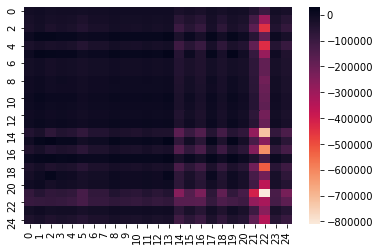

attn


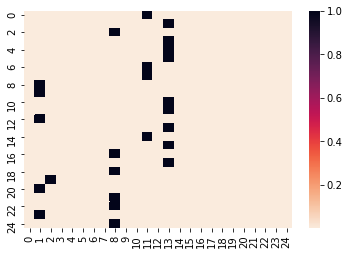

new sinkhorn


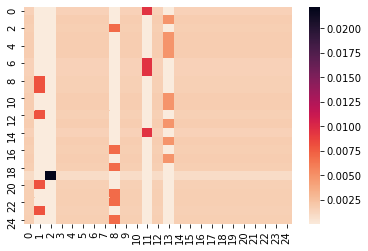

tensor([0.0407, 0.0400, 0.0223, 0.0407, 0.0407, 0.0407, 0.0407, 0.0407, 0.0414,
        0.0407, 0.0407, 0.0381, 0.0407, 0.0439, 0.0407, 0.0407, 0.0407, 0.0407,
        0.0407, 0.0407, 0.0407, 0.0407, 0.0407, 0.0407, 0.0407],
       grad_fn=<SumBackward1>)
tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
       grad_fn=<SumBackward1>)

W 0


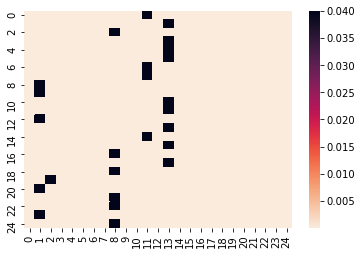

W 1


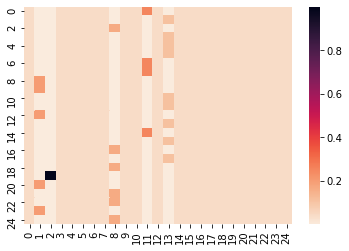

W 2


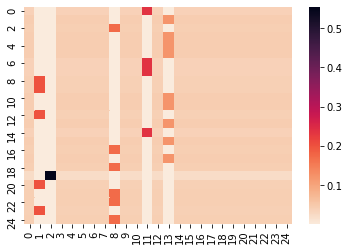

Mgrad


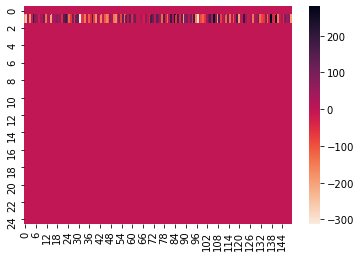

attgrad


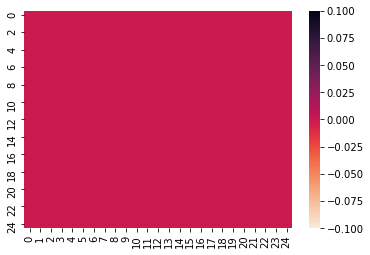

Wgrad


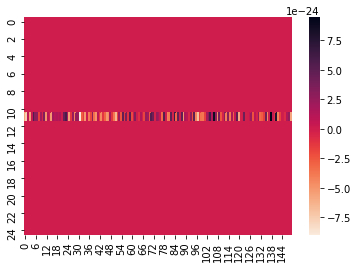

W2grad


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [22]:
cross_mats = []
for idx, (stx, lex) in enumerate(X.scope):
    y = y_embedding[stx:stx+lex]
    # these things vary because of the different types of embedding for diff models
    if model_type == "deepsets":
        yhat = yhat_embedding[stx:stx+lex]
    elif model_type == "molemb":
        yhat = yhat_embedding[idx][:lex]
    # print(y.shape, self.k.shape, self.q.shape, yhat.shape)
    M = 1/np.sqrt(crossatt.cross_att_dim) * torch.matmul(torch.matmul(y, crossatt.k), torch.matmul(crossatt.q.T, yhat.T))
#     M.clamp(-5, 5)
    
    print ("Model name:", model_name)
    print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
    if crossatt.args.cross_att_random:
        dim = np.random.randint(2)
        print ("random dim selected", dim)
    else:
        dim = 1
        
    print ("M")
    hmap(M)


    attn = torch.softmax(M, dim = dim) + crossatt.eps
    print ("attn")
    hmap(attn)
    W = attn/(len(attn))
    # if idx == 0:
    #     print (W.sum(axis = 0))
    #     print (W.sum(axis = 1))
    #     print ()
    W2 = sinkhorn_knopp(W, -0.1, numItermax=1)
    print ("new sinkhorn")
    hmap(W2)
    if idx == 0:
        print (W2.sum(axis = 0))
        print (W2.sum(axis = 1))
        print ()
    
    W_in = W
#     for idx2 in range(crossatt.args.cross_att_n_sinkhorn):
    for idx2 in range(3):
        print ("W",idx2)
        hmap(W)
        dim = 1 - dim
        W = (W.transpose(0,dim) / W.sum(axis = dim)).transpose(0,dim)
#         W = W/(len(W))
#         if idx == 0:
#             print (W.sum(axis = 0))
#             print (W.sum(axis = 1))
#             print ()
#     print ("W",idx2+1)
#     hmap(W)
    
    cross_mats.append(W2)
    
    print ("Mgrad")
    hmap(grad(M[1,1], yhat, retain_graph = True)[0])
    
    print ("attgrad")
    hmap(grad(attn[0,0], M, retain_graph = True)[0])
    
    print ("Wgrad")
    hmap(grad(W[1,1], yhat, retain_graph = True)[0])
    
    print ("W2grad")
    hmap(grad(W2[1,1], W, retain_graph = True)[0])
    
    if idx == 0:
        break

In [186]:
torch.matmul(y, crossatt.k)

tensor([[ 19.0138,   3.0727,  -8.1748,  ..., -12.8927,   9.2372,  12.0784],
        [ 22.3717,  -1.8025, -11.4092,  ...,  -4.6111,  14.9682,   7.4301],
        [ 23.8301,  -0.1072, -14.7613,  ...,  -6.2800,  20.4967,   7.6682],
        ...,
        [ 27.9034,  -2.5696, -12.8627,  ...,  -4.6769,  25.5728,  10.8489],
        [ 16.3927,  -1.6811, -14.2876,  ...,  -5.6947,  20.6895,  12.7963],
        [ 16.2909,  -1.8942, -10.9141,  ..., -14.0958,  10.7016,  14.6449]],
       grad_fn=<MmBackward>)

In [187]:
torch.matmul(crossatt.q.T, yhat.T)

tensor([[-2.5313e+03, -7.7122e+04, -6.0739e+03,  ...,  1.0759e+04,
          4.5583e+03,  2.1194e+03],
        [ 5.5592e+03,  8.4006e+03,  1.6394e+03,  ...,  4.2388e+03,
         -4.7890e+02, -5.1199e+03],
        [-3.0653e+03, -7.8344e+02, -1.0026e+03,  ..., -9.5947e+00,
          1.0232e+03,  6.0037e+03],
        ...,
        [ 8.0378e+03, -1.0006e+04,  8.7153e+03,  ..., -2.6069e+03,
         -5.7135e+03, -1.4561e+04],
        [ 5.1074e+03, -1.2216e+05, -1.3360e+04,  ...,  1.5583e+03,
         -1.1958e+02,  1.0353e+04],
        [-1.6576e+04, -6.5008e+04, -2.2429e+04,  ..., -1.6641e+04,
         -1.4193e+04, -1.7301e+03]], grad_fn=<MmBackward>)

In [188]:
cross_mats[0]

tensor([[1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04, 7.1929e-09, 1.5775e-04,
         1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04,
         1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04,
         1.5775e-04, 3.6372e-02, 1.5775e-04, 1.5775e-04, 1.5775e-04, 1.5775e-04,
         1.5775e-04],
        [1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6728e-03, 1.6656e-03,
         1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03,
         1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03,
         1.6656e-03, 1.7435e-05, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03,
         1.6656e-03],
        [1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6728e-03, 1.6656e-03,
         1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03,
         1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03, 1.6656e-03,
         1.6656e-03, 1.7435e-05, 1.6656e-03, 1.6656e-03, 1.6656e-

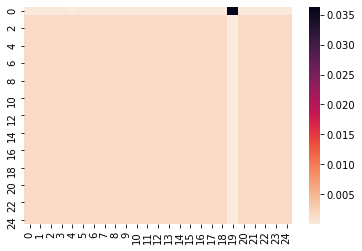

In [189]:
hmap(cross_mats[0])

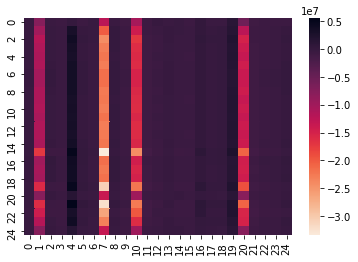

In [190]:
hmap(M)
plt.show()

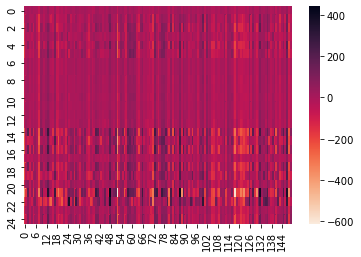

In [222]:
hmap(torch.matmul(y, crossatt.k))

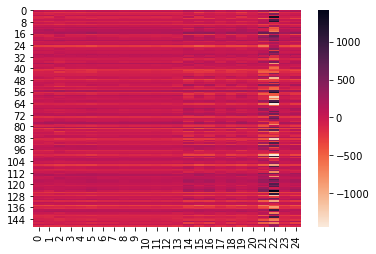

In [226]:
hmap(torch.matmul(crossatt.q.T, yhat.T))

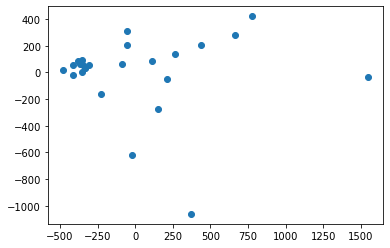

In [246]:
proj = project_2d(torch.matmul(y, crossatt.k))
plt.scatter(proj[0], proj[1])
plt.show()

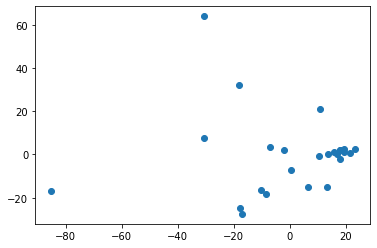

In [245]:
proj = project_2d(y)
plt.scatter(proj[0], proj[1])
plt.show()

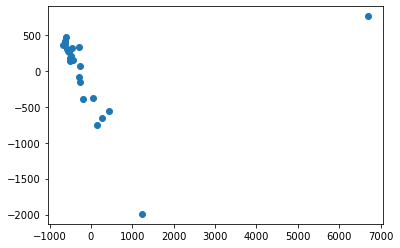

In [252]:
proj = project_2d(torch.matmul(crossatt.q.T, yhat.T).T)
plt.scatter(proj[0], proj[1])
plt.show()

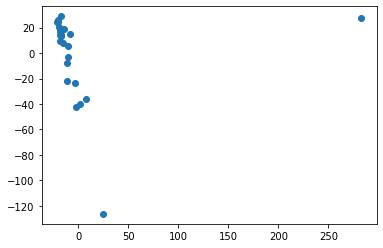

In [247]:
proj = project_2d(yhat)
plt.scatter(proj[0], proj[1])
plt.show()

In [235]:
torch.matmul(y, crossatt.k).shape

torch.Size([25, 150])

In [237]:
y.shape

torch.Size([25, 150])

In [240]:
crossatt.k.shape

torch.Size([150, 150])

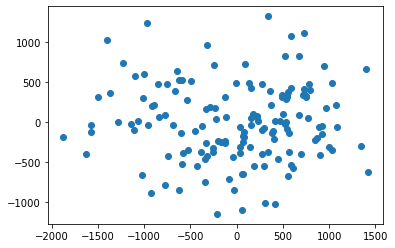

In [231]:
proj = project_2d(torch.matmul(crossatt.q.T, yhat.T))
plt.scatter(proj[0], proj[1])
plt.show()

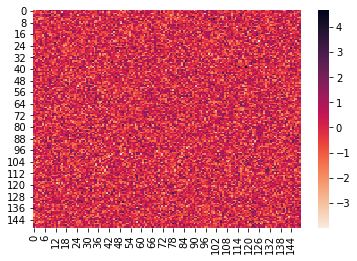

In [193]:
hmap(crossatt.q)

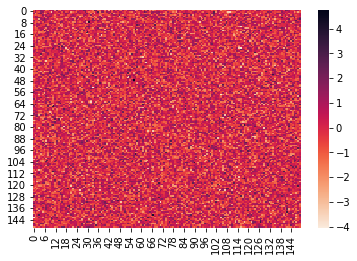

In [194]:
hmap(crossatt.k)

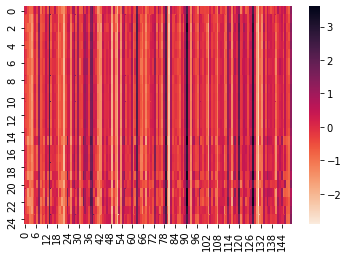

In [195]:
hmap(y)

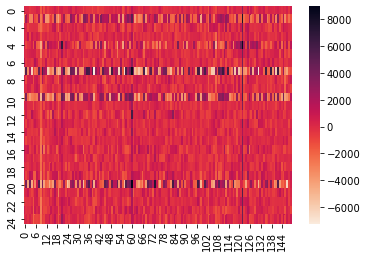

In [196]:
hmap(yhat)

In [197]:
cross_mats[0].sum(axis = 0)

tensor([0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401,
        0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401,
        0.0401, 0.0368, 0.0401, 0.0401, 0.0401, 0.0401, 0.0401],
       grad_fn=<SumBackward1>)

In [198]:
cross_mats[0].sum(axis = 1)

tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
       grad_fn=<SumBackward1>)

In [199]:
G_fgw = grad(fgw_loss_item, x_embedding, retain_graph = True)
G_euler = grad(pen_loss[2], bonds_logits, retain_graph = True)
G_k = grad(fgw_loss_item, crossatt.k, retain_graph = True, allow_unused = True)
G_q = grad(fgw_loss_item, crossatt.q, retain_graph = True, allow_unused = True)

print(G_euler[0].abs().mean().item())
print(G_fgw[0].abs().mean().item())
print()
print(np.mean((torch.sum(G_euler[0], dim = 1) == 0).cpu().detach().numpy()))
print(np.mean((torch.sum(G_fgw[0], dim = 1) == 0).cpu().detach().numpy()))
print()
print(symbols_logits.abs().mean().item())
print(bonds_logits.abs().mean().item())

0.0011412129970267415
4.239358531776816e-06

0.9379829198861326
0.0

964.6190185546875
1695.677490234375


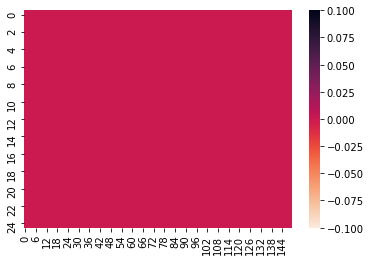

In [200]:
hmap(grad(cross_mats[idx][0,0], yhat, retain_graph = True)[0])

In [201]:
grad(cross_mats[idx][0,2], yhat, retain_graph = True)[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [202]:
grad(crossatt.q[0,0], yhat, retain_graph = True, allow_unused = True)

(None,)

In [203]:
crossatt.q

Parameter containing:
tensor([[-0.6140, -2.1059, -0.4167,  ...,  0.9857,  0.9073, -0.3704],
        [-1.0779, -1.1399, -0.3143,  ..., -0.0454, -1.3259, -0.3227],
        [-1.6297,  0.0859, -0.1080,  ..., -1.3794,  1.2690,  0.1917],
        ...,
        [ 1.1994, -1.3594, -2.1768,  ..., -1.2656,  1.7780,  0.8770],
        [ 1.7744,  0.4156, -0.0258,  ...,  0.3479,  0.7718,  2.5040],
        [ 1.3377, -1.6792, -0.1018,  ..., -0.7270,  0.0427,  0.3310]],
       requires_grad=True)

In [204]:
crossatt.q

Parameter containing:
tensor([[-0.6140, -2.1059, -0.4167,  ...,  0.9857,  0.9073, -0.3704],
        [-1.0779, -1.1399, -0.3143,  ..., -0.0454, -1.3259, -0.3227],
        [-1.6297,  0.0859, -0.1080,  ..., -1.3794,  1.2690,  0.1917],
        ...,
        [ 1.1994, -1.3594, -2.1768,  ..., -1.2656,  1.7780,  0.8770],
        [ 1.7744,  0.4156, -0.0258,  ...,  0.3479,  0.7718,  2.5040],
        [ 1.3377, -1.6792, -0.1018,  ..., -0.7270,  0.0427,  0.3310]],
       requires_grad=True)

# get 2d projections of embedding

In [205]:
x_embedding.shape

torch.Size([50, 70, 150])

In [227]:
def project_2d(dfr):
    yhat_np = dfr.cpu().detach().numpy()
    yhat_mean = np.mean(yhat_np.T, axis = 1)
    yhat_nomean = yhat_np - yhat_mean
    cov = np.cov(yhat_nomean.T)
    values, vectors = np.linalg.eig(cov)
    proj = vectors[:,:2].T.dot(yhat_nomean.T)
    return proj

Model name: model_deepsets-attention-sinknew-test3_12000
Type=deepsets, random=False, epoch=12000, index=0


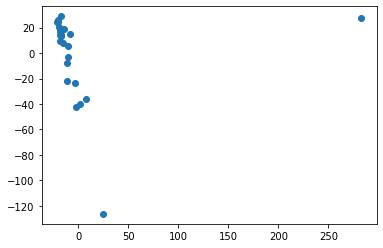

In [225]:
print ("Model name:", model_name)
print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
plt.scatter(proj[0], proj[1])
plt.show()

In [ ]:
yhat_np = yhat.cpu().detach().numpy()
yhat_mean = np.mean(yhat_np.T, axis = 1)
yhat_nomean = yhat_np - yhat_mean
cov = np.cov(yhat_nomean.T)
values, vectors = np.linalg.eig(cov)
proj = vectors[:,:2].T.dot(yhat_nomean.T)

In [37]:
np.linalg.eig(yhat_np)

LinAlgError: Last 2 dimensions of the array must be square

In [38]:
yhat_np.shape

(25, 150)

In [39]:
bonds_logits_softmaxed = nn.Softmax(dim = 1)(bonds_logits)

In [40]:
grad(bonds_logits_softmaxed[:,4].sum(), bonds_logits, retain_graph = True)[0].sum()

tensor(-1.7317e-05)

In [41]:
bonds_logits_softmaxed

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.9211e-18, 1.0501e-28, 8.4375e-34, 0.0000e+00, 1.0000e+00],
        [6.3155e-14, 7.8943e-25, 2.1647e-29, 0.0000e+00, 1.0000e+00],
        ...,
        [4.5429e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.0193e-09, 4.1305e-32, 2.3469e-35, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       grad_fn=<SoftmaxBackward>)

In [42]:
x_embedding.shape

torch.Size([1150, 150])

In [43]:
bond_idx = 0
smiles = []

yhat = []
yact = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    yhat.append(le)
    yact.append((bonds != 4).sum().item()/2.)
    print (mol_idx, yact[-1], le)
    print (smiles[-1])
    
yhat = np.array(yhat)
yact = np.array(yact)


0 24.0 25
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
1 15.0 16
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)S
2 55.0 29
CS123456789%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26CS1%27(C2)(C3)(C4)(C5)(C6)(C7)(C8)(C9)(C%10)(C%11)(C%12)(C%13)(C%14)(C%15)(C%16)(C%17)(C%18)(C%19)(C%20)(C%21)(C%22)(C%23)(P%24)C%25C%27%26
3 37.0 35
CS12(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C3C1C32
4 20.0 21
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
5 46.0 47
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
6 17.0 18
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)S
7 22.0 23
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
8 22.0 23
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
9 17.0 18
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)S
10 15.0 16
CS(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)(C)C
11 22.0 2

(array([ 2.,  2.,  2.,  5.,  7., 10., 11.,  5.,  3.,  3.]),
 array([-41. , -37.4, -33.8, -30.2, -26.6, -23. , -19.4, -15.8, -12.2,
         -8.6,  -5. ]),
 <BarContainer object of 10 artists>)

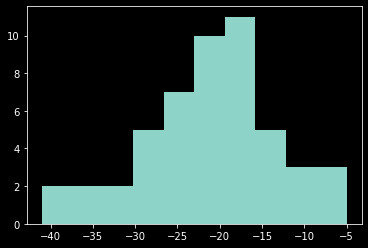

In [36]:
plt.hist(yact - yhat)

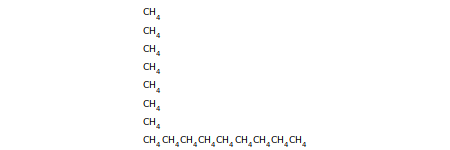

In [37]:
Chem.MolFromSmiles(smiles[1], sanitize = False)

In [38]:
np.arange(0,1000,100)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [106]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

In [107]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(7.9200, grad_fn=<MaxBackward1>)

In [108]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-{}-{}-manual2-".format(args.init_model, model_iter, datatype))

CCCCCC1(C)CC(CO)C1(O)CCOC
C=CCCCCCCC(N)(CC)C(CCC)C(N)CC(O)NC
CCCCC(C)CC(C)C(C)C(N)(NC(C)C)C(CSC)C(N)CC(O)NF
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)CC(O)NO
CCC1CN[SH](C)CC(CN)C(N)CCN1N
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)OC(O)NO
CCC1CCC12CC(CO)C2(O)OCN
NCOC1CC(N)S12CCC2
CNC1CN[SH](C)CC(CN)C(N)CCN1N
OCCC(O)(OCO)C1CCC1
CCCCC(O)C1CC(C)CCCCCCC1C
C=CCCC=CCCC(N)C(CCC)C(O)CC(O)NC
CCC1(O)OC(O)N(O)C(C)(CN(C)OC)C(C)C(C)(CC)C(O)C(N)(N)(NC(O)(O)O)C1CCCN(N)O.O
NCCC(O)(OCN)[SH]1CCC1
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)CC(O)NCl
CNC(N)(CCCC(C)CCOC)C(CSC)C(O)OC(O)NCl
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CCCCC(C)CC(C)C(C)C(N)(NC(C)O)C(CCCC)C(O)CC(O)NC
CCCC(C)(CCC)C1CCC1CC
CCCCCCCCC(N)(N)C(CCC)C(N)CC(O)NO
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CC1CCCC1C
CCCCCC1(C)CC(CC)C1(O)CCCC
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CC1CCCCCC(O)C(C(O)OC(O)OO)CC1C
C=CCCC(C)C(C)C(C)C(C)C(N)(OC(C)C)C(CCCC)C(O)CC(O)NC
CCC1CCC1C(O)(CCN)CCN
C=CCCC(C)CC(C)C(C)C(N)(CC(C)C)C(CCCC)C(O)CC(O)CC
C=CCCC(C)CC(C)C(C)C(N)(CC(C)C)C(CCCC)C(C)CC(O)NC
CC12CC1COC2O
CC1CCOC1O


In [27]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O'

In [67]:
tau = pen.tau
# tau = 0.001
# symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)
# symbols_nll, charges_nll, bonds_nll = -nn.LogSoftmax(dim=1)(symbols_logits/tau),\
#              -nn.LogSoftmax(dim=1)(charges_logits/tau), -nn.LogSoftmax(dim=1)(bonds_logits/tau)

def softmax(logits, tau):
#     logitsn = F.normalize(logits, dim = 1)
#     return -nn.LogSoftmax(dim=1)(logitsn/tau)
    return F.gumbel_softmax(tau = tau, dim=1, logits = logits)

symbols_nll = softmax(symbols_logits, tau)
charges_nll = softmax(charges_logits, tau)
bonds_nll = softmax(bonds_logits, tau)

In [68]:
pen.tau

0.05195383849590577

(array([201., 231., 302., 166., 129.,  31.,  15.,   3.,   0.,   1.]),
 array([ 47.78911,  64.59665,  81.40419,  98.21173, 115.01927, 131.82681,
        148.63435, 165.4419 , 182.24944, 199.05698, 215.86452],
       dtype=float32),
 <a list of 10 Patch objects>)

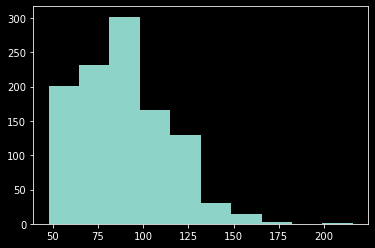

In [39]:
plt.hist(symbols_logits.norm(dim = 1).cpu().detach().numpy())

(array([  24.,   19.,   36.,   26.,   17.,   32.,   31.,   21.,   36.,
          33.,   37.,   35.,   64.,   66.,   97.,   71.,   65.,   86.,
          72.,   75.,  106.,   87.,   79.,   95.,   68.,   72.,   76.,
          61.,   81.,   70.,   63.,   71.,   53.,   74.,   68.,   62.,
          30.,   37.,   45.,   40.,   58.,   32.,   65.,   58.,   57.,
          55.,   50.,   64.,   82.,   32.,   38.,   50.,   59.,   44.,
          49.,   49.,   50.,   68.,   49.,   55.,   66.,   43.,   49.,
          92.,   82.,   55.,   79.,   63.,   89.,   84.,   65.,   75.,
         101.,   97.,   83.,  111.,   99.,  111.,  130.,  119.,  118.,
         137.,  127.,  147.,  109.,  161.,  210.,  198.,  219.,  271.,
         338.,  430.,  511.,  560.,  580.,  880., 1053., 1574., 2603.,
        8307.]),
 array([0.2980454 , 0.30506495, 0.3120845 , 0.31910405, 0.3261236 ,
        0.33314312, 0.34016266, 0.3471822 , 0.35420176, 0.3612213 ,
        0.36824086, 0.3752604 , 0.38227996, 0.38929948, 0.39631903

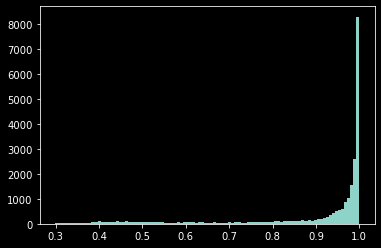

In [52]:
max_logits = torch.max(F.softmax(dim=1, input = bonds_logits), dim = 1).values.detach().cpu().numpy()
plt.hist(max_logits, bins = 100)

In [26]:
symbols_logits.shape

torch.Size([1079, 64])

<BarContainer object of 64 artists>

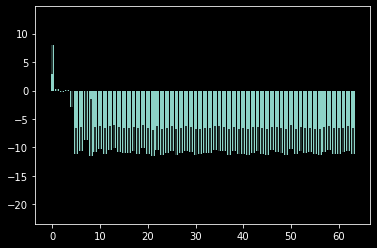

In [70]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

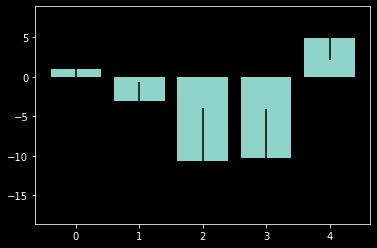

In [71]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [101]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([27,  4, 53,  ...,  4,  7, 50], device='cuda:0')

In [102]:
bonds_logits.sum(axis = 1)

tensor([-0.7168, -0.6918, -0.7858,  ..., -0.2435, -0.3567, -0.3224],
       device='cuda:0', grad_fn=<SumBackward1>)

In [103]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[1.1898e-07, 4.1788e-15, 1.1364e-11,  ..., 1.1246e-15, 4.4671e-12,
         2.6455e-06],
        [5.9730e-32, 3.8587e-35, 2.3728e-35,  ..., 2.7590e-26, 4.3688e-35,
         6.8968e-34],
        [2.3369e-16, 5.9282e-12, 9.6984e-11,  ..., 5.1900e-19, 7.2133e-17,
         2.6491e-13],
        ...,
        [1.0000e+00, 1.0524e-29, 1.8007e-29,  ..., 5.9074e-30, 3.6392e-36,
         2.7992e-31],
        [3.3421e-20, 3.4711e-14, 4.9880e-17,  ..., 4.9878e-09, 9.8660e-22,
         7.0411e-26],
        [5.2386e-27, 2.3484e-27, 5.3644e-35,  ..., 3.0511e-31, 3.9224e-33,
         6.2579e-37]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [104]:
bonds_nll

tensor([[30.4351, 34.9901, 82.9673, 68.6483, -0.0000],
        [35.5620, 39.7150, 82.7646, 71.0517, -0.0000],
        [36.0503, 39.9646, 83.9324, 70.3454, -0.0000],
        ...,
        [26.6836, 38.2859, 91.0719, 90.3248, -0.0000],
        [20.4135, 28.7948, 73.8399, 72.7646, -0.0000],
        [21.0419, 32.0101, 80.5401, 78.0148, -0.0000]], device='cuda:0',
       grad_fn=<NegBackward>)

In [105]:
torch.argmax(bonds_nll, dim = 1).unique(return_counts = True)

(tensor([2, 3, 4], device='cuda:0'),
 tensor([13527, 10041,     3], device='cuda:0'))

In [72]:
bonds_nll

tensor([[4.8684e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1608e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1414e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        ...,
        [3.8970e-18, 1.0000e+00, 3.2179e-41, 3.9096e-43, 7.6519e-09],
        [1.8544e-17, 6.8090e-20, 0.0000e+00, 5.7014e-10, 1.0000e+00],
        [0.0000e+00, 5.8267e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [73]:
bond_idx = 0
for st, le in Y.scope:
    bonds_nll_curr = bonds_nll[bond_idx:bond_idx + le**2,:].view(le, le, -1)
    print ((1 - bonds_nll_curr[:,:,4]).sum()/2)
    bond_idx += le**2

tensor(25.9540, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15.7227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30.8190, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26.7959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21.0293, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18.0473, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.4608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.6883, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4789, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8743, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.2297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29.8443, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.9637, device='cuda:0', g

In [75]:
1 - bonds_nll_curr[:,:,4]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2863e-01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.3452e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0364e-02, 0.0000e+00, 9.9963e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9987e-01, 1.9908e-05, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5497e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.4771e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2620e-01, 0.0000e+00, 0.0000e+00,
         9.1592e-01, 3.3100e-03, 0.0000e+00],
        [1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [118]:
symbols_logits.shape

torch.Size([1079, 64])

In [119]:
symbols_labels

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

# inspect module parameters

In [150]:
molopt_decoder.fc1_SYMBOLS

Linear(in_features=100, out_features=150, bias=True)

In [151]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

tensor([[ 13.7881,   0.6913,   3.3530,  ..., -10.6195,  -8.9924, -11.0378],
        [ 13.5698,  -1.3311,   4.9047,  ...,  -8.9976,  -7.9215, -10.1074],
        [  5.2691,  -6.6067,   3.9132,  ..., -13.3723, -13.1498, -14.1045],
        ...,
        [  2.3633,   0.6043,   8.5959,  ..., -12.3276, -12.1154, -13.7442],
        [ 16.1051,   0.3792,   4.5413,  ...,  -8.0192,  -7.4203,  -9.7780],
        [  8.6492,   4.9261,   0.4580,  ...,  -9.5743,  -9.4313, -10.6167]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [152]:
x_embedding

tensor([[-0.1335,  0.4283,  0.3699,  ..., -0.3710,  0.7165, -0.5101],
        [-0.8927,  1.3656,  0.6950,  ..., -1.0309, -0.1640, -0.0162],
        [-0.4414, -0.3376,  2.9654,  ...,  1.0029, -0.6166,  0.1708],
        ...,
        [ 0.9006,  0.2762, -0.7614,  ...,  1.1360,  0.2881, -0.2464],
        [-1.4002,  1.4269, -0.5393,  ..., -1.6091,  0.4275, -0.0564],
        [-0.5014,  0.6323,  0.1265,  ..., -1.6008, -0.1383,  0.4430]],
       device='cuda:0', grad_fn=<AddBackward0>)

# debug connectivity

In [153]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [154]:
for i in range(0, 2000):
    print (i, get_pen(1600))

FileNotFoundError: [Errno 2] No such file or directory: 'mol_opt/output_transformer10-onebatch/model_transformer10-onebatch-nonconstrained_1600'

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)